In [2]:
from aliases import *
import copy
from typing import Tuple
from senset import HLCA, PUC_ct, DE_test_ct, SncGeneSets
from senset.utils import construct_PU_results_table
from sklearn.decomposition import PCA, TruncatedSVD
from umap import UMAP
import grinch as gr
from itertools import combinations
from scipy.stats import ranksums
import textwrap
from senset.utils import pqvals
import seaborn.objects as so
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import LinearSegmentedColormap
import colorcet as cc
from textwrap import wrap

In [3]:
extension = "SNC-known-pca=10-prior=0.9-no-smoker"

In [11]:
pal = ['#465775', '#ef6f6c']
age_group_pal = ['#8338ec', '#ff006e', '#ffbe0b']
sex_colors = ['#439cfb', '#f1515e']
gs_overlap_colors = ['#f4f1de', '#e07a5f']

smoking_colors = {
    'N/A': '#ffffb3',
    'never': '#8dd3c7',
    'former': '#bebada',
    'active': '#fb8072',
}
senescence_colors = ['#8d99ae', '#c12f83']
senescence_colors_scatter = ['#9e0059', '#e0e1dd']
age_group_order = ['$\mathcal{Y}$', '$\mathcal{M}$', '$\mathcal{A}$']
cell_type_colors = sns.color_palette(cc.glasbey_light, n_colors=22)
pd.set_option('display.max_columns', None)

In [5]:
SNC = SncGeneSets(
    SenSet=f'dumps/SenSet-{extension}.txt',
    remove_downregulated=False,
)
gene_sets = SNC.gene_sets
print(SNC)

Gene Set module with keys:
	GO: 83
	Fridman: 90
	SenMayo: 125
	CellAge: 279
	union: 501
	SenSet: 106



In [6]:
hlca = HLCA('../SenSet/data/HLCA.h5ad', remove_smokers=False)
adata = hlca.adata

Removing 3427 cells with age='NaN'


In [7]:
age_group = np.where(hlca.age < 30, '$\mathcal{Y}$', '$\mathcal{M}$')
age_group[hlca.age >= 50] = '$\mathcal{A}$'
adata.obs['Age Group'] = age_group

  adata.obs['Age Group'] = age_group



In [8]:
table_df = pd.read_excel(f'dumps/Complete-{extension}.xlsx')

def get_col_items(col):
    items = table_df[col]
    items = npu(npc(items[~pd.isna(items)].str.split(', ').tolist()))
    return items

def count_col_items(col):
    items = table_df[col]
    items = Counter(npc(items[~pd.isna(items)].str.split(', ').tolist()))
    return items

up_genes = get_col_items('Up')
down_genes = get_col_items('Down')
up_genes_count = count_col_items('Up')
down_genes_count = count_col_items('Down')
assert np.in1d(up_genes, SNC.SenSet).all()
assert np.in1d(down_genes, SNC.SenSet).all()

In [9]:
markers = []

def _process(row, column):
    if pd.isna(row[column]):
        return
    for gene_name, statistic in zip(row[column].split(', '), eval(row[f"{column} statistic"])):
        markers.append({
            "Cell_Type": row['Cell Type'],
            "Gene": gene_name,
            "Regulation": column,
            "Statistic": statistic,
            "abs(Statistic)": np.abs(statistic),
        })

for i, row in table_df.iterrows():
    _process(row, 'Up')
    _process(row, 'Down')

markers_df = pd.DataFrame(markers)

In [10]:
CT_to_consider = npu(markers_df['Cell_Type'])
CT_to_indexed = {ct: f"{i + 1}. {ct}" for i, ct in enumerate(CT_to_consider)}
ct_column = [CT_to_indexed[ct] for ct in markers_df['Cell_Type']]
markers_df['Cell Type'] = ct_column

In [12]:
is_young = hlca.age < 30
is_med = (hlca.age >= 30) & (hlca.age < 50)
is_old = hlca.age >= 50

### Smokers Comparison

In [14]:
def check_cell_type(cell_type, gene_set, age_cond, age_cond_str):
    genes = getattr(SNC, gene_set)
    ad = adata[(adata.obs['cell_type'] == cell_type) & age_cond,
               np.in1d(adata.var['feature_name'], genes)]
    x_nosmoke = ad[ad.obs['smoking_status'] == 'never'].X.toarray()
    x_smoke = ad[ad.obs['smoking_status'] == 'active'].X.toarray()
    if x_nosmoke.shape[0] < 20 or x_smoke.shape[0] < 20:
        return None
    stat, pval = ranksums(x_smoke, x_nosmoke)

    out = []
    for gene_name, s, p in zip(ad.var['feature_name'], stat, pval):
        out.append({
            "Cell Type": cell_type,
            "Gene Set": gene_set,
            "Gene": gene_name,
            "Statistic": s,
            "P": p,
            "Age Group": age_cond_str,
        })

    return pd.DataFrame(out)

In [ ]:
dfs = []

for cell_type in tqdm(CT_to_consider):
    for gene_set in SNC.gene_sets:
        for age_group, age_group_str in zip([is_young, is_old], ['$\mathcal{Y}$', '$\mathcal{A}$']):
            res = check_cell_type(cell_type, gene_set, age_group, age_group_str)
            if res is not None:
                dfs.append(res)

smoke_df = pd.concat(dfs, ignore_index=True)
smoke_df['$-\log(p)$'] = -np.log10(smoke_df['P'] + 1e-200)  # cap pvals
smoke_df['Is Significant'] = smoke_df['P'] <= 0.05

### Dumping

In [16]:
to_use = [
    'alveolar type 1 fibroblast cell',
    'respiratory basal cell',
    'tracheobronchial smooth muscle cell',
    'type II pneumocyte',
    'CD4-positive, alpha-beta T cell',
    'CD8-positive, alpha-beta T cell',
]

In [17]:
dump_df = smoke_df[(smoke_df['Gene Set'] == 'SenSet') & (np.in1d(smoke_df['Cell Type'], to_use))]
young_dump_df = dump_df[dump_df['Age Group'] == '$\mathcal{Y}$']
old_dump_df = dump_df[dump_df['Age Group'] == '$\mathcal{A}$']

In [19]:
dumpable_dfs = {}

for (cell_type, ct_df) in old_dump_df.groupby('Cell Type'):
    sig_df = ct_df[ct_df['Is Significant']].copy()
    sig_df['Regulation'] = np.where(sig_df['Statistic'] > 0, 'Up', 'Down')
    sig_df['abs(Statistic)'] = np.abs(sig_df['Statistic'])
    sig_df.sort_values(['Regulation', 'abs(Statistic)'], inplace=True, ascending=False)
    sig_df['Age Group'] = 'A'
    dumpable_dfs[cell_type] = sig_df

In [14]:
condensed = []

for cell_type, _df in smoke_df.groupby('Cell Type'):
    for gene_set, g_df in _df.groupby('Gene Set'):
        for age_group, a_df in g_df.groupby('Age Group'):
            up = (a_df['Is Significant'] & (a_df['Statistic'] > 0)).mean()
            down = (a_df['Is Significant'] & (a_df['Statistic'] < 0)).mean()
            condensed.append({
                "Cell Type": cell_type,
                "Gene Set": gene_set,
                "Mean": up,
                "Regulation": "Up",
                "Age Group": age_group,
            })
            condensed.append({
                "Cell Type": cell_type,
                "Gene Set": gene_set,
                "Mean": down + up,
                "Regulation": "Down",
                "Age Group": age_group,
            })
condensed_df = pd.DataFrame(condensed)

$\mathcal{S}$
$\mathcal{Y}$


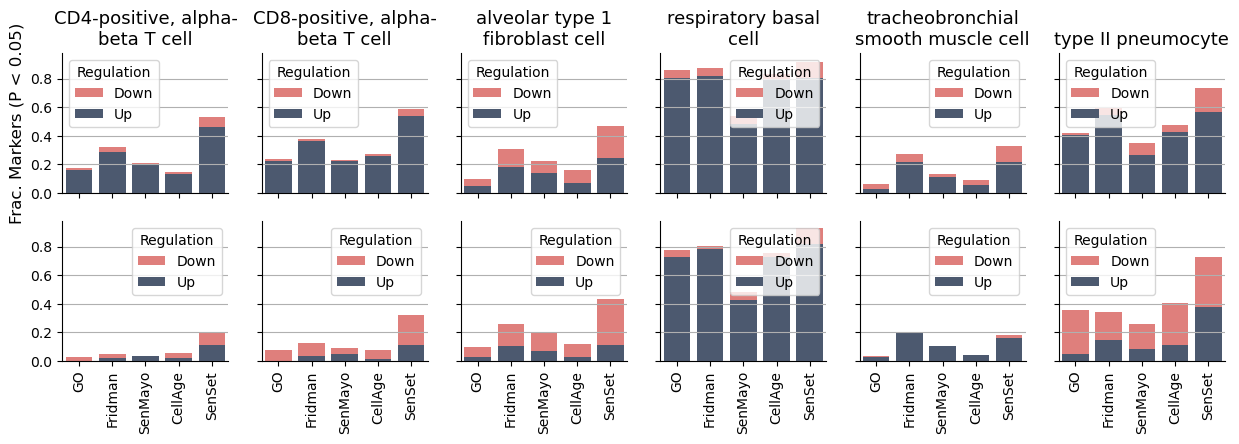

In [56]:
# to_use = ['alveolar type 1 fibroblast cell', 'elicited macrophage', 'respiratory basal cell', 'type II pneumocyte']

fig, axes = plt.subplots(ncols=len(to_use), nrows=2,
                         figsize=(len(to_use) * 2.5, 4),
                         sharey=True, sharex=True)

cc_df = condensed_df[np.in1d(condensed_df['Cell Type'], to_use)]

for row_i, ((age_group, _df), axs) in enumerate(zip(cc_df.groupby('Age Group'), axes)):
    print(age_group)
    for (cell_type, tmp_df), ax in zip(_df.groupby('Cell Type'), axs.flat):
        sns.barplot(
            tmp_df,
            x="Gene Set",
            y="Mean",
            order=SNC.gene_sets,
            palette=pal[::-1],
            hue="Regulation",
            hue_order=['Down', 'Up'],
            dodge=False,
            ax=ax,
        )
        sns.despine(ax=ax)
        ax.tick_params(axis='x', rotation=90)
        # colony.correct_font_size(ax)
        if row_i == 0:
            title = "\n".join(wrap(cell_type, 20))
            ax.set_title(title, fontsize=13)
            ax.set_ylabel('Frac. Markers (P < 0.05)', fontsize=12)
        else:
            ax.set_title('')
            ax.set_ylabel('')
        ax.set_xlabel('')
        ax.grid(axis='y')

        # ax.legend().remove()

# artist.savefig('figures/SenSet/smokers-comparison-all-sets.pdf')
plt.show()


## Reverse rows so that row 1 is young and row 2 is aged